# Prediksi Risiko Gagal Bayar Kredit Menggunakan Algoritma XGBoost

Notebook ini membahas proses analisis data, preprocessing, pemodelan, serta
evaluasi model XGBoost untuk memprediksi risiko gagal bayar kredit berdasarkan
data peminjaman nasabah.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, accuracy_score
)

from xgboost import XGBClassifier, plot_importance


## 1. Persiapan Data

Dataset yang digunakan adalah Loan Default Dataset yang berisi informasi
peminjaman nasabah beserta status gagal bayar.


In [15]:
df = pd.read_csv("Loan_default.csv")
df.head()


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


## Informasi dan Statistik Dataset


In [16]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [17]:
df.columns

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')

## Distribusi Kelas Target

Visualisasi ini digunakan untuk melihat apakah dataset bersifat seimbang
atau tidak seimbang (imbalanced).


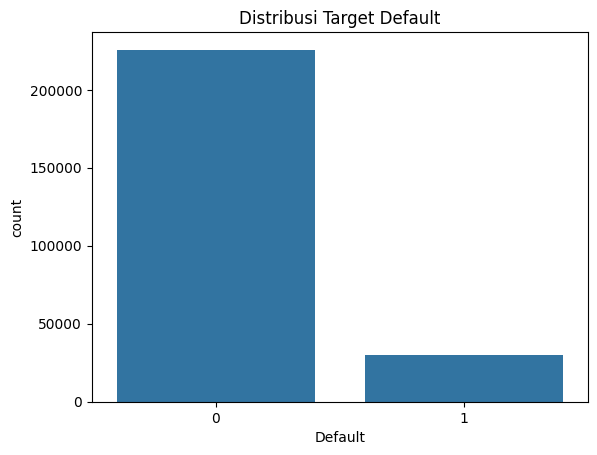

Default
0    225694
1     29653
Name: count, dtype: int64

In [18]:
sns.countplot(x='Default', data=df)
plt.title("Distribusi Target Default")
plt.show()

df['Default'].value_counts()


## Korelasi Antar Fitur Numerik


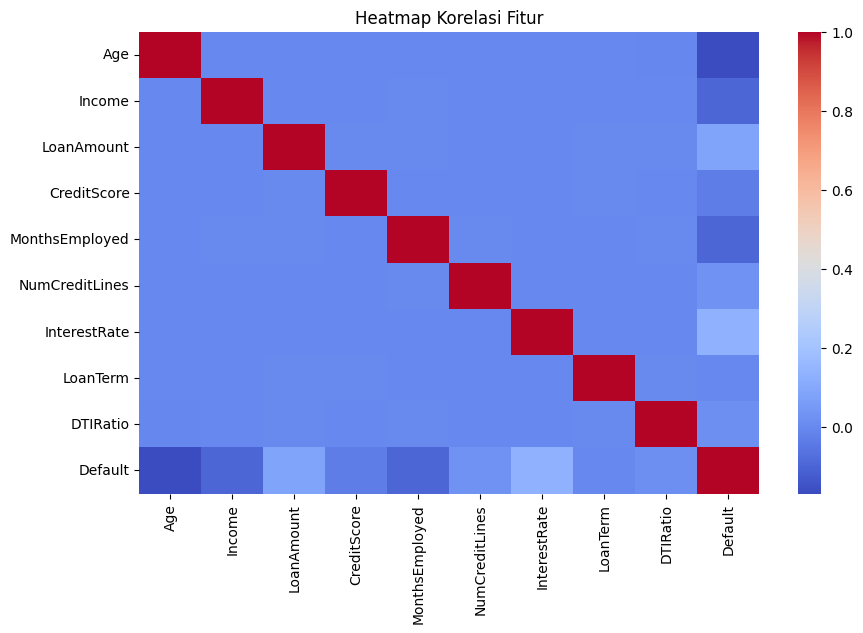

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()


## Identifikasi Fitur Numerik dan Kategorikal


In [20]:
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=['int64','float64']).columns


## Encoding Variabel Kategorikal

Label Encoding digunakan karena XGBoost berbasis pohon keputusan.


In [21]:
df_encoded = df.copy()
le_dict = {}

for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    le_dict[col] = le


## Penanganan Missing Values

Missing values dibiarkan karena XGBoost mampu menanganinya secara internal.


In [22]:
df_encoded.isnull().sum()


LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

## Pembagian Data Training dan Testing


In [23]:
X = df_encoded.drop('Default', axis=1)
y = df_encoded['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Baseline Model XGBoost


In [24]:
xgb_baseline = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_baseline.fit(X_train, y_train)
y_pred_baseline = xgb_baseline.predict(X_test)
accuracy_score(y_test, y_pred_baseline)


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:04:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.8849030742118661

## Penanganan Data Tidak Seimbang


In [25]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos


In [26]:
xgb_final = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False
)

xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict(X_test)
y_proba = xgb_final.predict_proba(X_test)[:,1]


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:04:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [27]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.71      0.81     45139
           1       0.23      0.67      0.34      5931

    accuracy                           0.70     51070
   macro avg       0.59      0.69      0.57     51070
weighted avg       0.86      0.70      0.75     51070



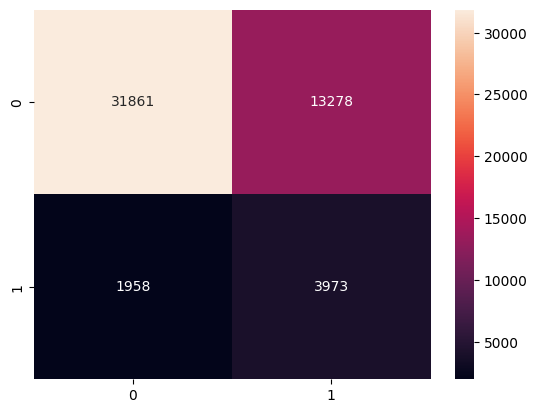

In [28]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


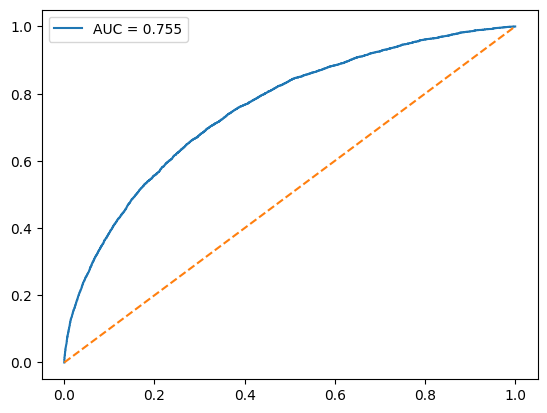

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()


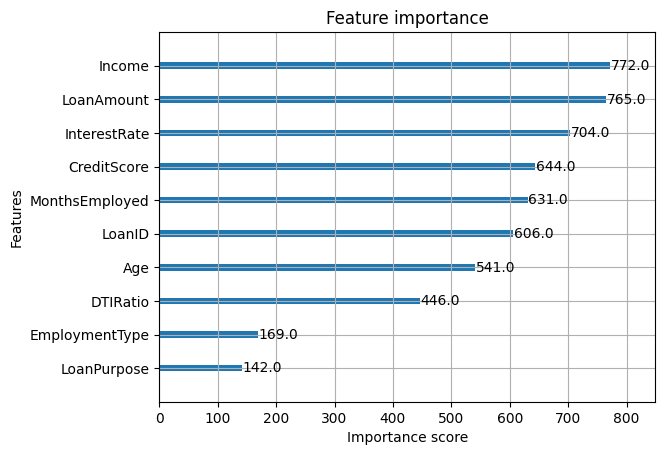

In [30]:
plot_importance(xgb_final, max_num_features=10)
plt.show()


In [31]:
joblib.dump(xgb_final, "xgb_model.pkl")
joblib.dump(le_dict, "encoder.pkl")


['encoder.pkl']

## Kesimpulan

Model XGBoost mampu memprediksi risiko gagal bayar dengan baik.
Penanganan data tidak seimbang dan tuning parameter memberikan
peningkatan performa yang signifikan.
